In [1]:
from catch import CatchEnv

import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import seaborn as sns

from collections import deque

In [2]:
class ReplayBuffer:
    def __init__(self, capacity, device):
        self.buffer = deque(maxlen=capacity)
        self.device = device

    def add(self, state, action, reward, next_state, done):
        self.buffer.append(tuple((state, action, reward, next_state, done)))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(np.array(states), dtype=torch.float32).to(self.device),
            torch.tensor(actions).to(self.device),
            torch.tensor(rewards).to(self.device),
            torch.tensor(np.array(next_states), dtype=torch.float32).to(self.device),
            torch.tensor(dones).to(self.device)
        )

    def __len__(self):
        return len(self.buffer)

In [3]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(self.calculate_conv_output_size(input_shape), 512)
        self.fc2 = nn.Linear(512, num_actions)
        
    def calculate_conv_output_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

In [4]:
class DQNAgent:
    def __init__(self,
                state_shape,
                num_actions,
                device,
                gamma,
                epsilon,
                epsilon_decay,
                epsilon_min,
                update_frequency,
                learning_rate,
                replay_buffer_size):

        self.state_shape = state_shape
        self.num_actions = num_actions
        self.device = device
        self.policy_net = DQN(state_shape, num_actions).to(device)
        self.target_net = DQN(state_shape, num_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.replay_buffer = ReplayBuffer(capacity=replay_buffer_size, device=self.device)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.update_frequency = update_frequency
        self.timestep = 0

    def act(self, state, test):
        if not test and random.random() < self.epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                q_values = self.policy_net(state)
                return q_values.argmax().item()

    def update(self, batch_size):
        if len(self.replay_buffer) < 1000:
            return

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)

        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device).long()

        # current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        # next_q_values = self.target_net(next_states).max(1)[0].detach()
        # expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # loss = F.smooth_l1_loss(current_q_values, expected_q_values.unsqueeze(1))
        
        q_values = self.policy_net(states)
        next_q_values = self.policy_net(next_states)

        # Compute Q-values for next states using the target network
        target_q_values = self.target_net(next_states)

        # Get the maximum Q-value index for the next states using the online network
        next_q_values_argmax = torch.argmax(next_q_values, dim=1)

        # Use the target network to estimate the Q-value for the selected action
        next_q_value_target = target_q_values.gather(1, next_q_values_argmax.unsqueeze(1)).squeeze(1)

        # Compute the target Q-values using the Double Q-learning update
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_value_target

        # Get the Q-values corresponding to the selected actions
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute the loss between current and target Q-values
        loss = F.smooth_l1_loss(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.timestep += 1

        if self.timestep % self.update_frequency == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay

In [5]:
# To match torch channel first format
def process_state(state):
    return state.transpose((2, 0, 1))

In [6]:
env = CatchEnv()
state_shape = env.state_shape()
num_actions = env.get_num_actions()

device = torch.device("mps" if torch.has_mps else "cpu")

learning_rate = 0.0001  # Learning rate for the optimizer
gamma = 0.99  # Discount factor for future rewards
epsilon = 1.0  # Exploration rate (initial)
epsilon_decay = 0.00025 # Decay rate for exploration rate
epsilon_min = 0.01  # Minimum exploration rate
batch_size = 32  # Number of experiences to sample from the replay buffer for each update
replay_buffer_size = 10000  # Maximum size of the replay buffer
target_network_update_frequency = 600  # Number of steps before updating the target network

In [7]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [8]:
def train_loop(agent):
    batch_size = 32
    num_episodes = 4000
    train_episodes = 10
    test_episodes = 10
    avg_test_rewards = []
    test_rewards = []

    consecutive_runs = 0

    for episode in range(num_episodes):
        # Train
        if episode % (train_episodes + test_episodes) < train_episodes:
            state = env.reset()
            state = process_state(state)
            done = False

            while not done: 
                action = agent.act(state, test=False)
                next_state, reward, done = env.step(action)
                next_state = process_state(next_state)
                agent.replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                agent.update(batch_size)

        # Test
        else:
            state = env.reset()
            state = process_state(state)
            done = False
            total_reward = 0

            while not done: 
                action = agent.act(state, test=True)
                next_state, reward, done = env.step(action)
                next_state = process_state(next_state)
                total_reward += reward
                state = next_state

            test_rewards.append(total_reward)

            if episode % 10 == 0:
                avg_test_rewards.append(np.mean(test_rewards[-10:]))
                print(f"({episode}) Last 10 episodes mean test reward:", avg_test_rewards[-1],
                       "Eps:", round(agent.epsilon, 2))
            
            # if len(avg_test_rewards) > 10 and np.mean(avg_test_rewards[-10:]) == 1:
            #     print("Training stopped due to 100 consecutive episodes with 1 total reward")
            #     break

    print("Training finished after", agent.timestep, "timesteps.")
    return avg_test_rewards

In [9]:
results = []
for i in range(5):
    set_seed(i)
    agent = DQNAgent(state_shape=state_shape, num_actions=num_actions,
            device=device, gamma=gamma, epsilon=epsilon, epsilon_decay=epsilon_decay,
            epsilon_min=epsilon_min, update_frequency=target_network_update_frequency,
            learning_rate=learning_rate, replay_buffer_size=replay_buffer_size)
    avg_test_rewards = train_loop(agent)
    np.save(f"results/group_44_catch_rewards_{i+1}.npy", avg_test_rewards)
    results.append(avg_test_rewards)

(10) Last 10 episodes mean test reward: 0.0 Eps: 1.0
(30) Last 10 episodes mean test reward: 0.3 Eps: 1.0
(50) Last 10 episodes mean test reward: 0.1 Eps: 1.0
(70) Last 10 episodes mean test reward: 0.0 Eps: 1.0
(90) Last 10 episodes mean test reward: 0.2 Eps: 1.0
(110) Last 10 episodes mean test reward: 0.2 Eps: 1.0
(130) Last 10 episodes mean test reward: 0.3 Eps: 1.0
(150) Last 10 episodes mean test reward: 0.2 Eps: 1.0
(170) Last 10 episodes mean test reward: 0.1 Eps: 1.0
(190) Last 10 episodes mean test reward: 0.2 Eps: 0.97
(210) Last 10 episodes mean test reward: 0.3 Eps: 0.95
(230) Last 10 episodes mean test reward: 0.7 Eps: 0.92
(250) Last 10 episodes mean test reward: 0.3 Eps: 0.89
(270) Last 10 episodes mean test reward: 0.1 Eps: 0.86
(290) Last 10 episodes mean test reward: 0.3 Eps: 0.84
(310) Last 10 episodes mean test reward: 0.1 Eps: 0.81
(330) Last 10 episodes mean test reward: 0.3 Eps: 0.78
(350) Last 10 episodes mean test reward: 0.2 Eps: 0.75
(370) Last 10 episodes m

[]

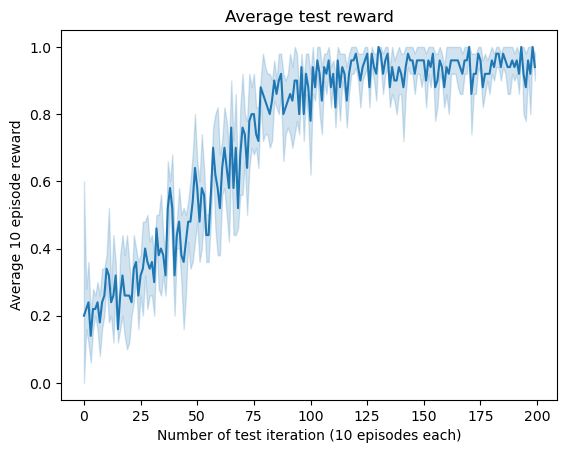

In [10]:
df = pd.DataFrame(results).melt()
ax = sns.lineplot(x="variable", y="value", data=df)
ax.set(xlabel='Number of test iteration (10 episodes each)',
       ylabel='Average 10 episode reward',
       title='Average test reward')
ax.plot()